In [1]:
## This script will walk through a basic analysis of the Acquisition and Performance data for the Data Science
## Challenge (Nov 9th and 10th 2019)
##
## Here you will find the tools necessary to open, read, and process the data as well as give you some 
## idea of the types of differing risk factors over the years. The key focus of your your analysis
## should be built around the "Zero_Bal_Cd" attribute. Look further into the script for more details
## on the different values this field can take on.
##
## In order to run this script you need to download data from this link: (you will have to create an account
## on the site but it's free)
##    https://loanperformancedata.fanniemae.com/lppub/index.html#Portfolio
##
## Additional details about these datasets (attribute names, allowable values, definitions, etc:
## is available from here:
##    https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html
##
## Download the data the 3rd Quarter for the years 2004, 2008, 2012, and 2016.
##
## Unzip the data files into the "RawData" directory and then execute this script.
##
## Make sure you have all the necessary python libraries listed below installed on your system
## 

In [2]:
import os
import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## print our current working directory to be sure we're operating in the right place
##
os.getcwd()

'/Users/monicakanasani/Downloads'

In [4]:
## create a list of the acquisition data file names
##
all_Acq_files = glob.glob(os.path.join("RawData/Acquisition*.txt"))

In [5]:
## print out the list to make sure we've got them all
##
all_Acq_files

['RawData/Acquisition_2004Q3.txt',
 'RawData/Acquisition_2012Q3.txt',
 'RawData/Acquisition_2016Q3.txt',
 'RawData/Acquisition_2008Q3.txt']

In [6]:
## read the contents of each acquisition file into a data frame
##
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None) for f in all_Acq_files)
df   = pd.concat(df_from_each_file, ignore_index=True)

In [7]:
## The files don't have names for each column so add the columns here
##
df.rename(columns={
                    0: 'Loan_ID',
                    1: 'Channel',
                    2: 'Seller',
                    3: 'Interest_Rate',
                    4: 'UPB',
                    5: 'Loan_Term',
                    6: 'Origination_Date',
                    7: 'First_Payment_Date',
                    8: 'LTV',
                    9: 'CLTV',
                    10: 'Num_Borrowers',
                    11: 'DTI',
                    12: 'Borrower_FICO',
                    13: 'First_Time_Buyer',
                    14: 'Loan_Purpose',
                    15: 'Dwelling_Type',
                    16: 'Unit_Count',
                    17: 'Occupancy',
                    18: 'State',
                    19: 'Zip',
                    20: 'Insurance%',
                    21: 'Product',
                    22: 'Co_Borrower_FICO',
                    23: 'Mortgage_Insurance_Type',
                    24: 'Relocation_Indicator'}, inplace=True)

In [8]:
## Now grab a listing of all the performance files in the RawData directory
##
all_perf_files = glob.glob(os.path.join( "RawData/Performance_*.txt"))

In [9]:
## display a listong of the performance files to make sure the year/quarter aligns
## with the acquisition files
##
all_perf_files

['RawData/Performance_2012Q3.txt',
 'RawData/Performance_2016Q3.txt',
 'RawData/Performance_2008Q3.txt',
 'RawData/Performance_2004Q3.txt']

In [10]:
## read in the data from each of the performance files and concatenate the
## data together into a single dataframe names "perf_df" and while we're reading the data in only include
## the columns we actually want for this analysis.
##
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None
                                 ,usecols=[0,1,3,4,5,11,12]
                                 , names = ['Loan_ID', 'Period', 'Current_IR','Current_UPB', 'Age',
                                            'Mod_Ind','Zero_Bal_Cd']
                                 ,dtype = { 'Loan_ID' : np.int64, 'Current_IR' : np.float64, 
                                           'Current_UPB': np.float64}
                                ) for f in all_perf_files)
perf_df   = pd.concat(df_from_each_file, ignore_index=True)

In [11]:
## Modify the date field ("Period") to be a number for easier manipulation
## later on in the script
## 
perf_df['Period']=perf_df['Period'].apply(str).str[6:].apply(int)*100+perf_df['Period'].apply(str).str[:2].apply(int)

## Select the latest period in the data frame as we're concerned with the most recent loan status
##
idx = perf_df.groupby(['Loan_ID'])['Period'].transform(max) == perf_df['Period']

## Create a new data frame with just the latest period record
## 
perf_df_new = perf_df[idx].copy()


In [12]:
## In looking at the FAQ dor the datasets we know that if the zero balance code is null then the loan is current
## meaning it's paid up correctly. It's not late, or paid off early, or in default so we don't really care
## about those records as regards our analysis.
##
perf_df_new.Zero_Bal_Cd.fillna(0,inplace=True)

## Also, some of the loans are missing the UPB (unpaid balance). We can't use that data in building our model
## so we'll just drop those loans from the dataframe
##
perf_df_new.dropna(inplace=True)

## create a mapping of the available zero_balance_code numbers and their meanings
##
zero_bal_cd_map = {0:'Current',1:'Prepaid',2:'Third Party Sale',3:'Short Sale',
                   6:'Repurchase',9:'REO',15:'Note Sale',16:'RPL Loan Sale'}
perf_df_new['Zero_Bal_Cd'] = perf_df_new['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)

## display a listing of the updated performance data 
##
perf_df_new.head()


,Loan_ID,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd
81,100002679724,201906,3.625,110549.80,82,N,Current
150,100003137281,201805,3.375,147781.08,68,N,Prepaid
234,100004790326,201906,4.125,219852.60,84,N,Current
268,100006404894,201504,3.000,123368.58,33,N,Prepaid
305,100008536293,201508,3.250,159596.31,36,N,Prepaid


In [13]:
## Now that we've cleaned up the acquisition and performance data, merge them into a single integrated
## data frame that we'll call "loan_df"
##
loan_df = pd.merge(df,perf_df_new,how='inner',on='Loan_ID')

## display the first several rows from the combined dataset
##
loan_df.head()

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,...,Product,Co_Borrower_FICO,Mortgage_Insurance_Type,Relocation_Indicator,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd
0,100001458647,R,"CITIMORTGAGE, INC.",5.625,297000,360,05/2004,07/2004,49,61.0,...,FRM,NaN,NaN,N,201309,5.625,251567.64,111,N,Prepaid
1,100004788186,C,"BANK OF AMERICA, N.A.",5.750,50000,180,08/2004,10/2004,25,25.0,...,FRM,753.0,NaN,N,201207,5.750,12621.76,94,N,Prepaid
2,100008528816,R,OTHER,5.000,80000,180,08/2004,10/2004,75,75.0,...,FRM,678.0,NaN,N,201508,5.000,40214.78,131,N,REO
3,100014656651,C,"BANK OF AMERICA, N.A.",6.300,55000,240,07/2004,09/2004,80,80.0,...,FRM,NaN,NaN,N,201402,6.300,37473.50,114,N,Prepaid
4,100021529837,C,"BANK OF AMERICA, N.A.",5.875,140000,360,07/2004,09/2004,80,80.0,...,FRM,794.0,NaN,N,201010,5.875,119759.31,74,N,Prepaid


In [14]:

loan_df.isnull().sum()



Loan_ID                          0
Channel                          0
Seller                           0
Interest_Rate                    0
UPB                              0
Loan_Term                        0
Origination_Date                 0
First_Payment_Date               0
LTV                              0
CLTV                             4
Num_Borrowers                   65
DTI                          40037
Borrower_FICO                 3450
First_Time_Buyer                 0
Loan_Purpose                     0
Dwelling_Type                    0
Unit_Count                       0
Occupancy                        0
State                            0
Zip                              0
Insurance%                 1678310
Product                          0
Co_Borrower_FICO           1017720
Mortgage_Insurance_Type    1678310
Relocation_Indicator             0
Period                           0
Current_IR                       0
Current_UPB                      0
Age                 

In [15]:
## Assign Defaults for the missing values in the loans dataframe
##
loan_df.Mortgage_Insurance_Type.fillna(0,inplace=True)
loan_df['Insurance%'].fillna(0,inplace=True)
loan_df.Num_Borrowers.fillna(1,inplace=True)
loan_df.CLTV.fillna(loan_df.LTV,inplace=True)
loan_df.drop('Co_Borrower_FICO',axis=1,inplace=True)

In [16]:
loan_df.isnull().sum()

Loan_ID                        0
Channel                        0
Seller                         0
Interest_Rate                  0
UPB                            0
Loan_Term                      0
Origination_Date               0
First_Payment_Date             0
LTV                            0
CLTV                           0
Num_Borrowers                  0
DTI                        40037
Borrower_FICO               3450
First_Time_Buyer               0
Loan_Purpose                   0
Dwelling_Type                  0
Unit_Count                     0
Occupancy                      0
State                          0
Zip                            0
Insurance%                     0
Product                        0
Mortgage_Insurance_Type        0
Relocation_Indicator           0
Period                         0
Current_IR                     0
Current_UPB                    0
Age                            0
Mod_Ind                        0
Zero_Bal_Cd                    0
dtype: int

In [17]:
## Drop any records that still have null values - we don't want to include them in the model / analysis
##
loan_df.dropna(inplace=True)
data=loan_df.copy()



In [18]:
## We'll do some analysis against the FICO (credit score) of the borrower
## Create several bins based on the FICO score range and add the calculated FICO bin score
## to each record in the dataframe
##
FICO_bins = [0,620,660,700,740,780,850]
FICO_labels = ['0-620', '620-660','660-700','700-740','740-780','780+']
loan_df['FICO_bins'] = pd.cut(loan_df['Borrower_FICO'],bins=FICO_bins,labels=FICO_labels)

Term_bins =[0,180,360]
Term_labels =['<=15 Years','<= 30 Years']
loan_df['Term_bins'] = pd.cut(loan_df['Loan_Term'],bins=Term_bins,labels=Term_labels)

zero_bal_cd_map = {'Current':'Current','Prepaid':'Prepaid','Third Party Sale':'Underperforming','Short Sale':'Underperforming',
                   'Repurchase':'Underperforming','REO':'Underperforming','Note Sale':'Underperforming','RPL Loan Sale':'Underperforming'}
loan_df['Current_Status'] = loan_df['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)

loan_df['Origin_Month'],loan_df['Origin_Year'] = loan_df['First_Payment_Date'].str.split('/', 1).str

df = loan_df[loan_df['Origin_Year'].isin(['2004','2008','2012','2016'])]

In [19]:
## Build a table showing the current status and total for each status type by year
##
df.groupby(['Origin_Year','Current_Status']).agg({'Loan_ID':'count'})

Loan_ID
Origin_Year Current_Status          
2004        Current            23358
            Prepaid           318565
            Underperforming    12093
2008        Current            24646
            Prepaid           296382
            Underperforming    19573
2012        Current           383238
            Prepaid           330469
            Underperforming     1007
2016        Current           514154
            Prepaid           108063
            Underperforming      551

In [20]:
## Create a new dataframe that holds the first 100,000 records
##
df2 = df.groupby('Origin_Year').head(100000)

In [21]:
## display another table showing the total number of each status by year
##
df2.groupby(['Origin_Year','Current_Status']).agg({'Loan_ID':'count'})

Loan_ID
Origin_Year Current_Status          
2004        Current             6556
            Prepaid            90026
            Underperforming     3418
2008        Current             7212
            Prepaid            87017
            Underperforming     5771
2012        Current            53775
            Prepaid            46070
            Underperforming      155
2016        Current            82548
            Prepaid            17352
            Underperforming      100

In [22]:
## Dump some info about the attributes that make up our dataframe
##
## Out of this list of attributes, which ones (and with what values) correlate the most with prepaid and defaulted
## mortages for each of the 4 years? Is there some attribute that remains significant across all four years?
## These are the "risk factors" we're interested in having you find in the data and display in some visually
## interesting way.
##
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 1832084
Data columns (total 35 columns):
Loan_ID                    400000 non-null int64
Channel                    400000 non-null object
Seller                     400000 non-null object
Interest_Rate              400000 non-null float64
UPB                        400000 non-null int64
Loan_Term                  400000 non-null int64
Origination_Date           400000 non-null object
First_Payment_Date         400000 non-null object
LTV                        400000 non-null int64
CLTV                       400000 non-null float64
Num_Borrowers              400000 non-null float64
DTI                        400000 non-null float64
Borrower_FICO              400000 non-null float64
First_Time_Buyer           400000 non-null object
Loan_Purpose               400000 non-null object
Dwelling_Type              400000 non-null object
Unit_Count                 400000 non-null int64
Occupancy                  400000 non-

In [23]:
## Write our current data frame out to a file. This will allow us to pick up and continue our
## analysis without going through all the previous work to clean and structure
## the data correctly.
##
df2.to_csv('Processed_loans.csv',index=False)

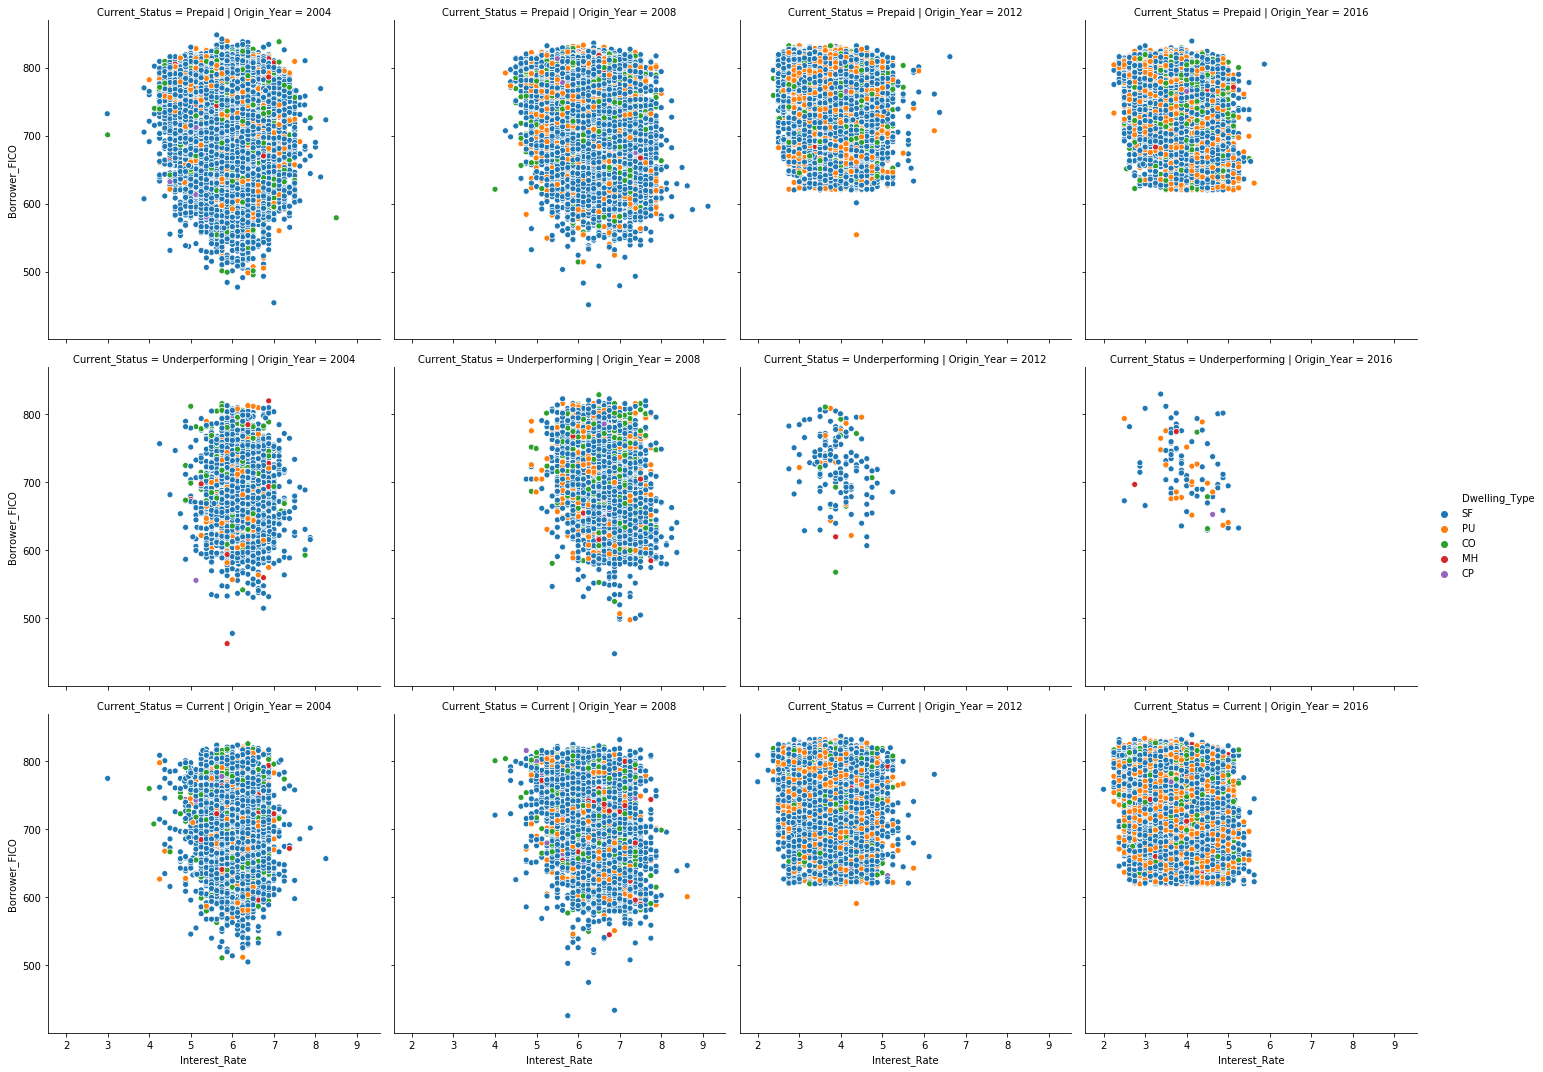

In [24]:
## Create and display a plot showing the distribution by year for the Borrower FICO score vs
## current, underperforming, and prepaid (paid off early) loans
##
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df2
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()

In [25]:
## Rebalance the record set by Dwelling Type into a new data frame (df3). We're doing this because the Single
## Family data (individual family homes) is far larger than the other types of homes (multi-family, etc) and we want
## a more balanced view of the data. You could go back and do a deeper analysis by home type and look for risk
## factors on that basis, or by zip code, number of borrowers, etc...
##
g = df2.groupby(['Origin_Year','Dwelling_Type'])
df3 = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
df3.info()
df3.head()
#print( df3['LTV'].min(),  df3['LTV'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 35 columns):
Loan_ID                    4340 non-null int64
Channel                    4340 non-null object
Seller                     4340 non-null object
Interest_Rate              4340 non-null float64
UPB                        4340 non-null int64
Loan_Term                  4340 non-null int64
Origination_Date           4340 non-null object
First_Payment_Date         4340 non-null object
LTV                        4340 non-null int64
CLTV                       4340 non-null float64
Num_Borrowers              4340 non-null float64
DTI                        4340 non-null float64
Borrower_FICO              4340 non-null float64
First_Time_Buyer           4340 non-null object
Loan_Purpose               4340 non-null object
Dwelling_Type              4340 non-null object
Unit_Count                 4340 non-null int64
Occupancy                  4340 non-null object
State                      43

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,...,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd,FICO_bins,Term_bins,Current_Status,Origin_Month,Origin_Year
0,299869592060,R,"JPMORGAN CHASE BANK, NA",6.125,61000,360,06/2004,08/2004,67,73.0,...,6.125,56579.55,62,N,Prepaid,780+,<= 30 Years,Prepaid,08,2004
1,139588696116,R,OTHER,6.000,100000,360,12/2003,02/2004,66,66.0,...,2.625,73951.33,185,Y,Current,700-740,<= 30 Years,Current,02,2004
2,219961011977,R,"GMAC MORTGAGE, LLC",5.500,276000,180,06/2004,07/2004,69,69.0,...,5.500,263246.96,13,N,Prepaid,780+,<=15 Years,Prepaid,07,2004
3,139527490472,B,OTHER,6.375,126000,360,06/2004,08/2004,70,70.0,...,6.375,88652.80,179,N,Current,740-780,<= 30 Years,Current,08,2004
4,116402813605,C,"BANK OF AMERICA, N.A.",6.250,135000,360,08/2004,10/2004,79,79.0,...,6.250,111046.62,132,N,Prepaid,780+,<= 30 Years,Prepaid,10,2004


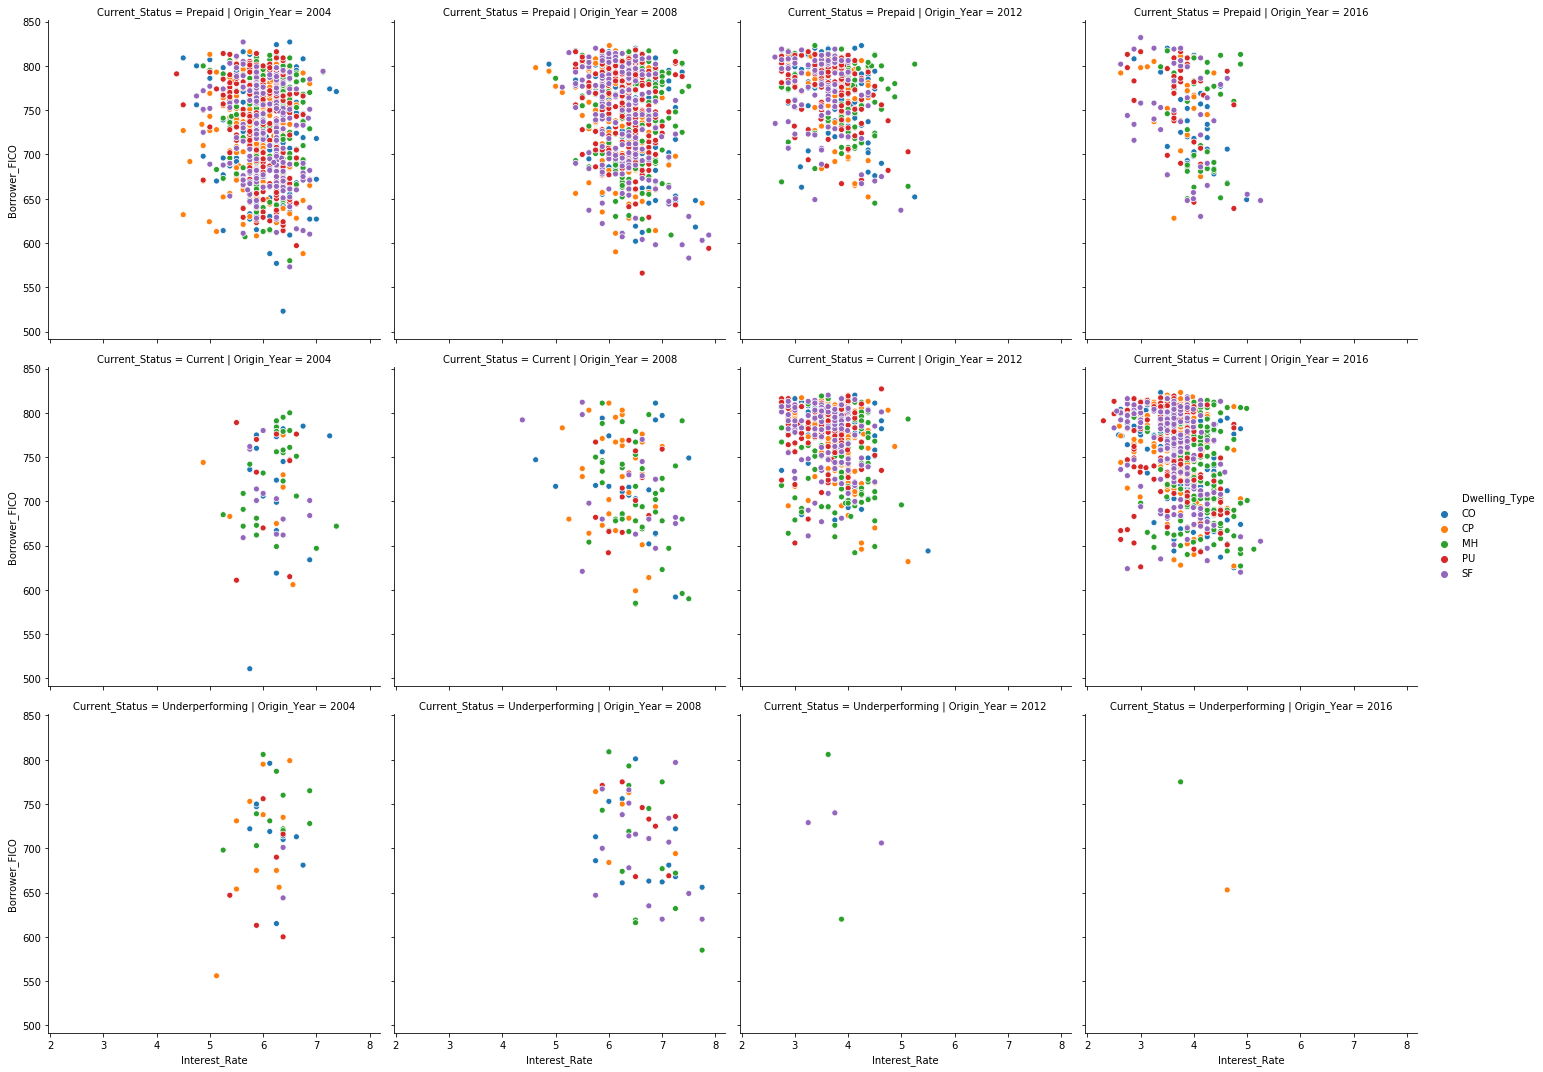

In [26]:
## Redisplay the graph based on the same attributes used above
##
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df3#.query('Current_Status != "Prepaid"'), #kind='line', 
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()

In [27]:
print(loan_df.shape)


(2038201, 35)


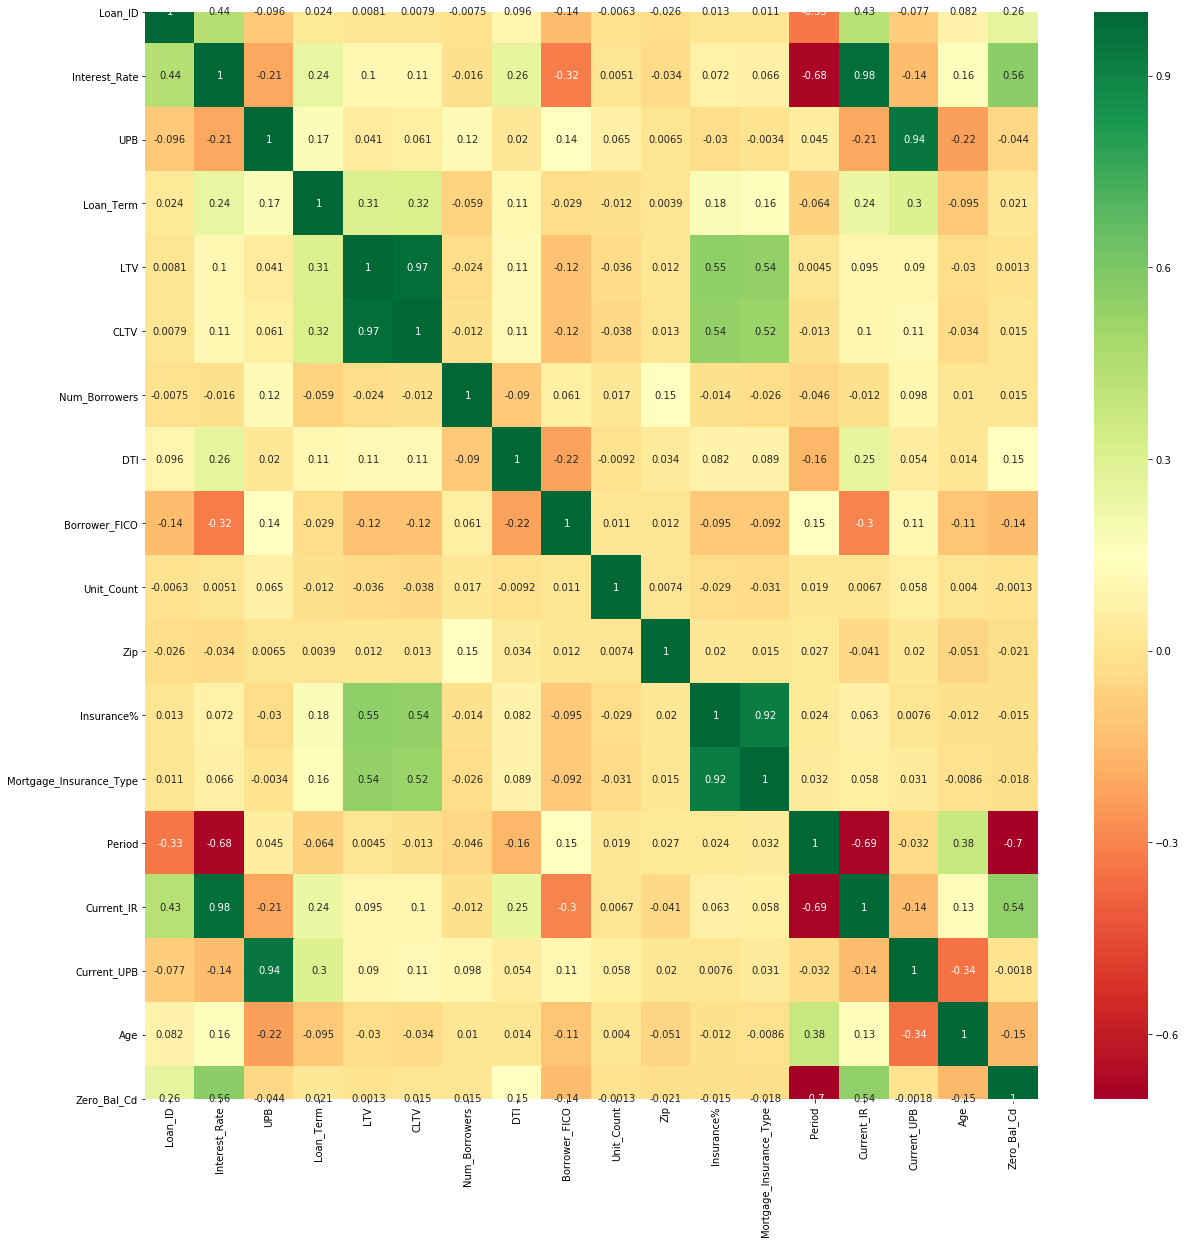

In [28]:
loan=df3.copy()
loan['Zero_Bal_Cd']=loan['Zero_Bal_Cd'].astype('category').cat.codes
#X = loan.iloc[:,0:34]  #independent columns
#y = loan.iloc[:,-1]    #target column i.e price 
#get correlations of each features in dataset
corrmat = loan.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(loan[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [29]:
bar= df2.groupby(['Origin_Year','FICO_bins','Current_Status']).agg({'Loan_ID':'count'})
bar.columns = ["_".join(x) for x in bar.columns.ravel()]
bar.head()


L_o_a_n___I_D
Origin_Year FICO_bins Current_Status                
2004        0-620     Current                    480
                      Prepaid                   4080
                      Underperforming            338
            620-660   Current                   1150
                      Prepaid                  10294

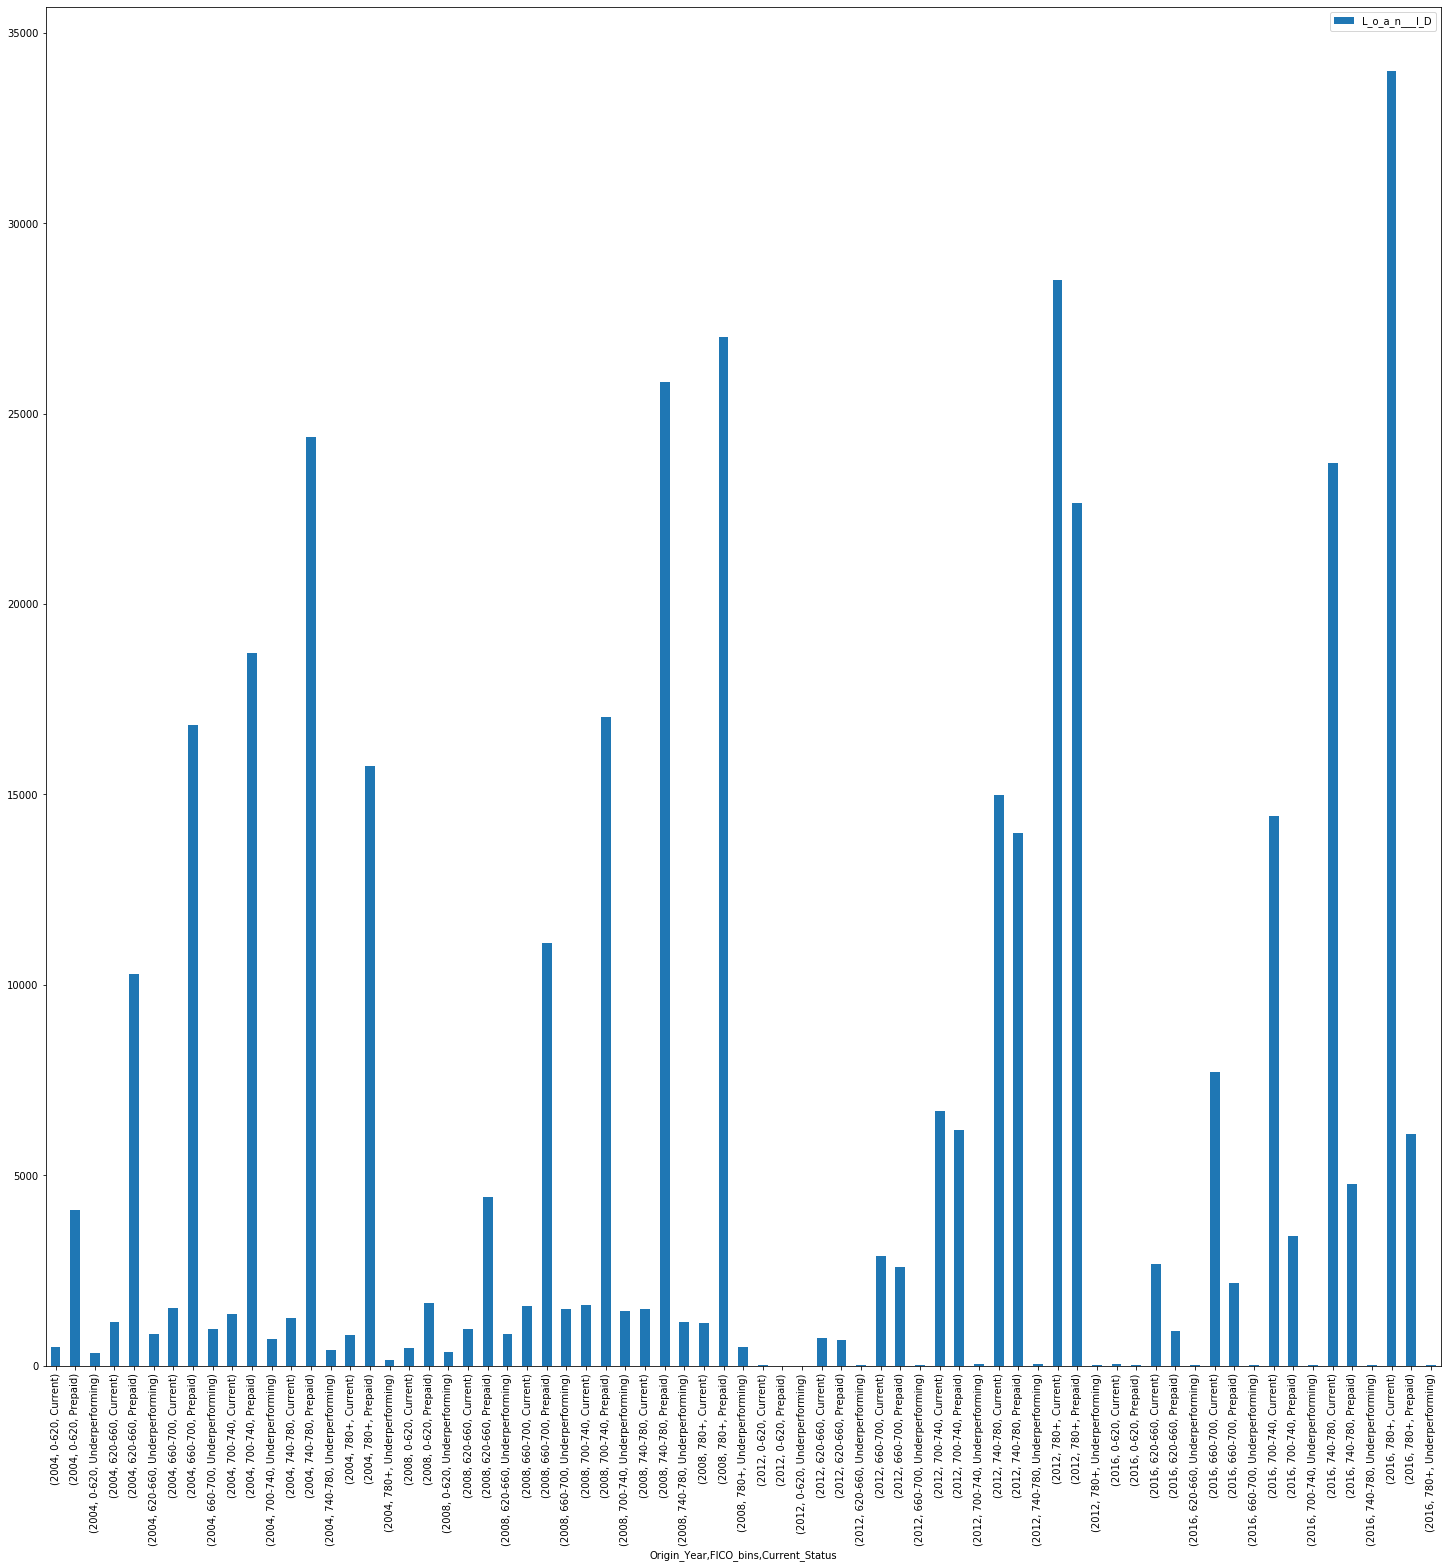

In [30]:
bar.plot.bar(figsize=(25,25))
#plt.figure(figsize=(20,20))



In [31]:

print(data.head())

        Loan_ID Channel                 Seller  Interest_Rate     UPB  \
0  100001458647       R     CITIMORTGAGE, INC.          5.625  297000   
1  100004788186       C  BANK OF AMERICA, N.A.          5.750   50000   
2  100008528816       R                  OTHER          5.000   80000   
3  100014656651       C  BANK OF AMERICA, N.A.          6.300   55000   
4  100021529837       C  BANK OF AMERICA, N.A.          5.875  140000   

   Loan_Term Origination_Date First_Payment_Date  LTV  CLTV  ...  Insurance%  \
0        360          05/2004            07/2004   49  61.0  ...         0.0   
1        180          08/2004            10/2004   25  25.0  ...         0.0   
2        180          08/2004            10/2004   75  75.0  ...         0.0   
3        240          07/2004            09/2004   80  80.0  ...         0.0   
4        360          07/2004            09/2004   80  80.0  ...         0.0   

   Product  Mortgage_Insurance_Type Relocation_Indicator  Period Current_IR  \
0

In [43]:
np.log(df3.var(axis=0))

Loan_ID                    49.859119
Interest_Rate               0.545584
UPB                        23.290013
Loan_Term                   8.691408
LTV                         5.759320
CLTV                        5.763887
Num_Borrowers              -1.323057
DTI                         4.862721
Borrower_FICO               7.888514
Unit_Count                 -3.647001
Zip                        11.621257
Insurance%                  4.591058
Mortgage_Insurance_Type    -1.684580
Period                     12.254071
Current_IR                  0.544880
Current_UPB                23.233946
Age                         7.343695
dtype: float64

In [32]:
datas=loan_df.copy()
ydata=loan_df.copy()
Channel = pd.get_dummies(datas['Channel'],drop_first=True)
Seller = pd.get_dummies(datas['Seller'],drop_first=True)
Origination_Date = pd.get_dummies(datas['Origination_Date'],drop_first=True)
First_Payment_Date = pd.get_dummies(datas['First_Payment_Date'],drop_first=True)
First_Time_Buyer = pd.get_dummies(datas['First_Time_Buyer'],drop_first=True)
Loan_Purpose = pd.get_dummies(datas['Loan_Purpose'],drop_first=True)
Dwelling_Type = pd.get_dummies(datas['Dwelling_Type'],drop_first=True)
Occupancy = pd.get_dummies(datas['Occupancy'],drop_first=True)
State = pd.get_dummies(datas['State'],drop_first=True)
Product = pd.get_dummies(datas['Product'],drop_first=True)
Mod_Ind = pd.get_dummies(datas['Mod_Ind'],drop_first=True)
FICO_bins = pd.get_dummies(datas['FICO_bins'],drop_first=True)
Term_bins = pd.get_dummies(datas['Term_bins'],drop_first=True)

Current_Status = pd.get_dummies(datas['Current_Status'],drop_first=True)

Origin_Month = pd.get_dummies(datas['Origin_Month'],drop_first=True)
Origin_Year = pd.get_dummies(datas['Origin_Year'],drop_first=True)



#DeviceInfo = pd.get_dummies(test_set['DeviceInfo'],drop_first=True)
datas.drop(['Channel','Seller','Origination_Date','First_Payment_Date','First_Time_Buyer','Loan_Purpose','Dwelling_Type','Occupancy','State','Product','Relocation_Indicator','Mod_Ind',
            'FICO_bins','Term_bins','Current_Status','Origin_Month','Origin_Year','Zero_Bal_Cd'],axis=1,inplace=True)
datas = pd.concat([datas,Channel,Seller,Origination_Date,First_Payment_Date,First_Time_Buyer,Loan_Purpose,Dwelling_Type
,Occupancy,State,Product,Mod_Ind,FICO_bins,Term_bins,Current_Status,Origin_Month,Origin_Year],axis=1)
ydata['Zero_Bal_Cd']=ydata['Zero_Bal_Cd'].astype('category').cat.codes


datas.head(2)
datas.columns
print(datas.shape)
print(ydata.shape)

(2038201, 442)
(2038201, 35)


In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = datas.iloc[:,0:441]  #independent columns
y = ydata.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(50,'Score'))  #print 10 best features

             Specs         Score
0          Loan_ID  1.034720e+12
15     Current_UPB  9.724053e+09
2              UPB  8.550767e+09
16             Age  9.592755e+06
10             Zip  2.399266e+06
176        10/2005  2.038200e+06
336        12/2005  2.038200e+06
432           2005  2.038200e+06
439           2014  2.038194e+06
427           2000  2.038194e+06
436           2010  2.038185e+06
428           2001  2.038151e+06
433           2006  2.038125e+06
437           2011  2.038102e+06
440           2015  2.037780e+06
429           2002  2.037639e+06
434           2007  2.037430e+06
430           2003  2.034125e+06
435           2008  1.697600e+06
431           2004  1.684185e+06
438           2012  1.323487e+06
13          Period  1.240612e+06
152        08/2010  1.146479e+06
312        10/2010  1.146479e+06
337        12/2006  1.019063e+06
3        Loan_Term  9.087451e+05
177        10/2006  8.917683e+05
8    Borrower_FICO  8.815633e+05
168        09/2014  8.735117e+05
181       

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [35]:
X = ydata[['Interest_Rate', 'UPB', 'Loan_Term','LTV','Num_Borrowers','Borrower_FICO','DTI','Insurance%','Period','Current_Status','Current_UPB']]
y = ydata['Zero_Bal_Cd']

X=X.iloc[1:10000]
y=y.iloc[1:10000]
print(X.shape)


(9999, 11)


In [36]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
Train_data1= X.apply(label_encoder.fit_transform)
Train_data1.shape
train_features, test_features, train_labels, test_labels = train_test_split(Train_data1, y, test_size = 0.30, random_state = 42)



In [72]:
train_features, test_features, train_labels, test_labels = train_test_split(Train_data1, y, test_size = 0.30, random_state = 42)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.02 degrees.
Accuracy: 98.98 %.


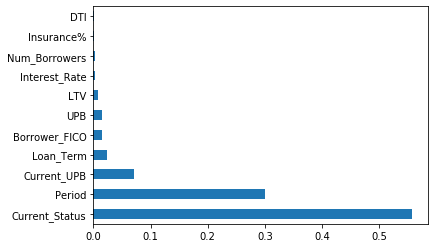

In [50]:

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(train_features, train_labels)  
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
#print(clf.feature_importances_)
predictions = clf.predict(test_features)

#print(np.log(clf.feature_importances_))
# Calculate feature importances
importances = clf.feature_importances_
# Sort feature importances in descending order
feat_importances = pd.Series(clf.feature_importances_, index=Train_data1.columns)
feat_importances.nlargest(11).plot(kind='barh')


In [38]:
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=42, solver='lbfgs',
                         #multi_class='multinomial').fit(train_features, train_labels)
logreg = LogisticRegression(C=1e20, solver='lbfgs', multi_class='multinomial')
logreg.fit(train_features, train_labels)

predictions=logreg.predict(test_features)

errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
#y_score = clf.decision_function(test_features)
#from sklearn.metrics import average_precision_score
#average_precision = average_precision_score(test_labels, y_score)

#print('Average precision-recall score: {0:0.2f}'.format(
 #     average_precision))


Mean Absolute Error: 0.17 degrees.
Accuracy: -inf %.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
state = 12  
test_size = 0.30  
  
X_train, X_test, y_train, y_test = train_test_split(Train_data1, y,  
    test_size=test_size, random_state=state)
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
score = xgb_clf.score(X_test, y_test)
print(score)

0.992
